<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Traffic-forecasting/blob/main/Notebooks/EDA_traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [2]:
! pip install -qq adtk
import adtk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from tqdm import tqdm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from matplotlib import style
import statsmodels.api as sm
import os ,datetime
from adtk.data import validate_series
from adtk.detector import PersistAD
from datetime import datetime
%matplotlib inline
warnings.filterwarnings('ignore')
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# **Load Raw Dataset**

In [3]:
!gdown 113Jq2I2ZHWj0CwxdLxt3yBID_53RroCR # Load dataset
!unzip -qq "/content/IntraTM.zip" -d "/content/files" # unzip to a folder called files

Downloading...
From: https://drive.google.com/uc?id=113Jq2I2ZHWj0CwxdLxt3yBID_53RroCR
To: /content/IntraTM.zip
100% 10.8M/10.8M [00:00<00:00, 31.9MB/s]


# **EDA**

## a)Create a text file

We used linux command "ls" to collect all files names in a txt file to use later, then read that file and store it in a list


In [4]:
!ls "/content/files" >> "/content/file_names.txt" # Create a text file and store all files' names inside

with open('/content/file_names.txt','r') as file: # read this file
    file_names_list =file.read().splitlines()

print('We have created a text file including all html files names ')
print('*'*100)
print("1st name in this txt file is:\t\t",file_names_list[0])
print("2nd name in this txt file is:\t\t",file_names_list[1])
print("3rd name in this txt file is:\t\t",file_names_list[1])
print("...\t\t\t\t\t ...")
print("...\t\t\t\t\t ...")
print("...\t\t\t\t\t ...")
print("Nth name in this txt file is:\t\t",file_names_list[-1])

We have created a text file including all html files names 
****************************************************************************************************
1st name in this txt file is:		 IntraTM-2005-01-01-00-30.xml
2nd name in this txt file is:		 IntraTM-2005-01-01-00-45.xml
3rd name in this txt file is:		 IntraTM-2005-01-01-00-45.xml
...					 ...
...					 ...
...					 ...
Nth name in this txt file is:		 IntraTM-2005-01-31-23-45.xml


## b)Generate features using created txt file

We used parsing to look at html files and extract each traffic for each path denoted by src_id and dst_id. Next, we store them in different dataframes. After that we merged all dataframes together to have a bigger dataframe covering all traffics for all paths.

In [5]:
def create_list_of_dfs(files_names):

  """Input: names of files in the dataset folder as a list
     Output: a list of dataframes for all files"""


  dataframe_list =  list()

  for index,file_name in enumerate(tqdm(files_names,"We are creating a dataframe for each html file.\t Please wait: ")): # Iterate over files

      df = pd.DataFrame({})
      file_path = '/content/files/'+ file_name

      tree = ET.parse(file_path) # parsing the file
      root = tree.getroot()
      date = file_name.split(".")[0].split("IntraTM-")[1] # extracting only date from file_name
      #eg : file_path="/content/files/IntraTM-2005-01-01-00-30.xml" ,
      #date = 2005-01-01-00-30


      # fixed variables to store values
      src_id_list  = list()
      dst_id_list = list()
      traffic_list =  list()


      for src in root.findall(".//src"):  # finding where we have src in html file
          src_id = src.get('id') #  receive src_id

          for dst in src.findall('dst'): # run a loop for that src to find all destinations
              dst_id = dst.get('id')  # receive dst id
              traffic = dst.text   # dst value

              src_id_list.append(int(src_id)) # store src_id
              dst_id_list.append(int(dst_id)) # store dst_id
              traffic_list.append(float(traffic)) # store traffic

      # add values to the dataframe
      df.insert(loc=0,column="src_id",value=src_id_list)
      df.insert(loc=1,column="dst_id",value=dst_id_list)
      df.insert(loc=2,column=f'{date}',value=traffic_list)

      # add dataframe to a list
      dataframe_list.append(df)

  return dataframe_list


# Call Function
#############################################################################
dataframe_list = create_list_of_dfs(files_names=file_names_list)

number_of_files = len(dataframe_list)
print('Number_of_files:',number_of_files)
print(f'\nFor each file, we have created a separate dataframe like the following dataframes. This means that now we have {number_of_files} dataframes as many as the number of files')




# Let's see two dataframes
print('First dataframe')
display(dataframe_list[0])
print('Second dataframe')
display(dataframe_list[1])

We are creating a dataframe for each html file.	 Please wait: 100%|██████████| 2941/2941 [00:14<00:00, 197.68it/s]

Number_of_files: 2941

For each file, we have created a separate dataframe like the following dataframes. This means that now we have 2941 dataframes as many as the number of files
First dataframe


,src_id,dst_id,2005-01-01-00-30
0,12,12,396708.2311
1,12,13,28093.7511
2,12,19,16916.5600
3,12,23,3662.8089
4,12,8,6552.9333
...,...,...,...
472,15,14,0.4622
473,15,11,496.4711
474,15,9,3781.9644
475,15,17,889.2267


Second dataframe


,src_id,dst_id,2005-01-01-00-45
0,12,12,338875.5644
1,12,13,28485.3422
2,12,19,11769.3422
3,12,23,1950.5067
4,12,8,5445.9111
...,...,...,...
470,15,14,3.1644
471,15,11,493.4844
472,15,9,888.7289
473,15,17,8000.8178


In [6]:
# It's time to merge all dataframes togheter using pd.merge and outer mode.

df = dataframe_list[0]                      # Initialize the merged DataFrame with the first DataFrame in the list
for dataframe in tqdm(dataframe_list[1:],"We are merging all dataframes together.\t Please wait: "):  # Iterate over the remaining DataFrames and perform an outer join
    df = pd.merge(df, dataframe, on=['src_id', 'dst_id'], how='outer')

df.to_csv('traffic.csv',index=False)             #Save as a csv file
print('This is the dataframe which includes features for different paths')
print('*'*100)

display(df)

We are merging all dataframes together.	 Please wait: 100%|██████████| 2940/2940 [01:52<00:00, 26.22it/s]


This is the dataframe which includes features for different paths
****************************************************************************************************


,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,12,12,396708.2311,338875.5644,341894.5422,347749.5822,320159.4933,336569.9733,304732.9422,318965.9822,...,311502.9422,317854.7644,315334.9156,320295.8133,318063.6711,320748.4711,298609.4489,297175.1556,305258.2222,310534.2756
1,12,13,28093.7511,28485.3422,38402.6756,31250.8356,50818.0000,20076.4000,33443.3600,40365.1111,...,30722.8444,31104.5422,47739.3156,35189.5644,33934.6667,30320.1689,25305.5378,26145.2978,28801.8756,30300.6667
2,12,19,16916.5600,11769.3422,5830.6311,7052.6489,6173.0222,4775.5111,5676.6489,4924.9511,...,3370.6400,1122.3911,1256.7911,2634.7289,3196.2667,4596.8444,7102.2844,5395.0400,4077.1556,10089.4489
3,12,23,3662.8089,1950.5067,2293.3778,1915.7244,1556.5333,1623.6089,1072.9422,855.4222,...,194.0889,726.8267,4217.2444,16669.8222,17209.4222,8732.4267,62.8800,412.2133,166.9067,119.0400
4,12,8,6552.9333,5445.9111,5831.0578,5757.1556,5453.6000,5178.4000,7083.3333,8414.4267,...,2915.8933,2589.1467,4792.2933,4280.5689,3852.2133,2539.4667,2017.9289,1540.2044,1812.3022,1205.4667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.8178,NaN,NaN,0.8178,NaN,1.6356,0.8178,NaN,0.8178
519,16,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,20,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## c)Load features  

In [7]:
traffic_dataframe = pd.read_csv("/content/traffic.csv")
display(traffic_dataframe)
print('*'*200)
print('As shown above, we can see that in our dataframe some self_loop are avaiable and some NaN values for other paths. So we have to address them')

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,12,12,396708.2311,338875.5644,341894.5422,347749.5822,320159.4933,336569.9733,304732.9422,318965.9822,...,311502.9422,317854.7644,315334.9156,320295.8133,318063.6711,320748.4711,298609.4489,297175.1556,305258.2222,310534.2756
1,12,13,28093.7511,28485.3422,38402.6756,31250.8356,50818.0000,20076.4000,33443.3600,40365.1111,...,30722.8444,31104.5422,47739.3156,35189.5644,33934.6667,30320.1689,25305.5378,26145.2978,28801.8756,30300.6667
2,12,19,16916.5600,11769.3422,5830.6311,7052.6489,6173.0222,4775.5111,5676.6489,4924.9511,...,3370.6400,1122.3911,1256.7911,2634.7289,3196.2667,4596.8444,7102.2844,5395.0400,4077.1556,10089.4489
3,12,23,3662.8089,1950.5067,2293.3778,1915.7244,1556.5333,1623.6089,1072.9422,855.4222,...,194.0889,726.8267,4217.2444,16669.8222,17209.4222,8732.4267,62.8800,412.2133,166.9067,119.0400
4,12,8,6552.9333,5445.9111,5831.0578,5757.1556,5453.6000,5178.4000,7083.3333,8414.4267,...,2915.8933,2589.1467,4792.2933,4280.5689,3852.2133,2539.4667,2017.9289,1540.2044,1812.3022,1205.4667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.8178,NaN,NaN,0.8178,NaN,1.6356,0.8178,NaN,0.8178
519,16,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,20,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


********************************************************************************************************************************************************************************************************
As shown above, we can see that in our dataframe some self_loop are avaiable and some NaN values for other paths. So we have to address them


In [8]:
column_names = traffic_dataframe.columns       # store column names
timestamps = column_names[2:]                  # Store timestamps(features). Timestamps starts from 2nd column.

## d) Change type float64 of features to flaot 32
We did this to decrease the computations during different process.

In [9]:
#change float 64 to float32 for timestamps to decrease computation in training part
print("*"*100)
print('Original inforamtion of dataframe:')
print("*"*100)
traffic_dataframe.info()
print("*"*100)
print('Updated inforamtion of dataframe with lower memory:')
print("*"*100)
traffic_dataframe[timestamps] = traffic_dataframe[timestamps].astype(np.float32)
traffic_dataframe.info()

****************************************************************************************************
Original inforamtion of dataframe:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Columns: 2943 entries, src_id to 2005-01-31-23-45
dtypes: float64(2941), int64(2)
memory usage: 11.7 MB
****************************************************************************************************
Updated inforamtion of dataframe with lower memory:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Columns: 2943 entries, src_id to 2005-01-31-23-45
dtypes: float32(2941), int64(2)
memory usage: 5.9 MB


## e) Address NaN Values

In [10]:
print('In the following, you can see the number of NaN values in each row:\n')
print('Row      No_NaN')
print('___      ______')
nan_counts = traffic_dataframe.isnull().sum(axis=1)
nan_counts


In the following, you can see the number of NaN values in each row:

Row      No_NaN
___      ______


0         0
1         0
2         0
3         1
4         0
       ... 
517    2935
518    2821
519    2939
520    2939
521    2939
Length: 522, dtype: int64

In [11]:
# Step 1) Removing. We are to remove traffics(rows) with nan values more than 25%

index_list_to_remove  = list()
nan_counts_index = nan_counts.index
nan_count_values = nan_counts.values
for nan_value_index,nan_value  in zip(nan_counts_index,nan_count_values):
  if (nan_value/number_of_files)*100 >25:
    index_list_to_remove.append(nan_value_index)

print("This indexes have more nan values, so we need to remove them")
print(index_list_to_remove)

print('*'*200)
traffic_dataframe.drop(index_list_to_remove,inplace=True)
traffic_dataframe.reset_index(inplace=True)
traffic_dataframe.drop(['index'],axis=1,inplace=True)
print('We updated dataframe. Now the rows with more than 25 % NaN values eliminated\n')

This indexes have more nan values, so we need to remove them
[13, 33, 54, 66, 75, 77, 83, 87, 96, 98, 127, 137, 159, 180, 202, 213, 216, 223, 244, 245, 264, 286, 298, 299, 300, 304, 309, 326, 336, 337, 352, 365, 366, 385, 407, 429, 451, 472, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521]
********************************************************************************************************************************************************************************************************
We updated dataframe. Now the rows with more than 25 % NaN values eliminated



In [12]:
print('But we have still several Nan Values for the rows with less than 25% NaN Values:\n')
print('Row      No_NaN')
print('___      ______')
traffic_dataframe.isnull().sum(axis=1)

But we have still several Nan Values for the rows with less than 25% NaN Values:

Row      No_NaN
___      ______


0       0
1       0
2       0
3       1
4       0
       ..
434     0
435    25
436     0
437     0
438     0
Length: 439, dtype: int64

In [13]:
# Step 1) Filling rows, having NaN values yet but less than 25 %
traffic_dataframe = traffic_dataframe.T
traffic_dataframe.columns = [f'traffic_{i}' for i in range(439)]
traffic_dataframe.fillna(axis='index',method="ffill",inplace= True) # Fill these NaN values with forward fill method avaiable in fillna function

# Chech NaN values again to make sure our dataframe does not have any NaN values
number_of_nans = traffic_dataframe.isnull().sum(axis=1).values
sum =0
for item in number_of_nans:
  if item >0:
    sum +=1

if sum >0:
  print('Oppps. This dataframe has NaN values yet.')
else:
  print("Great. This dataframe does not have any NaN values")

traffic_dataframe = traffic_dataframe.T
traffic_dataframe.index.name = 'index'

Great. This dataframe does not have any NaN values


## f) Plot graph

In [14]:
def plot_graph(dataframe,row,decompose=False,additional_title= 'Orginal'):

  """
  Input: dataframe, a row, decompuse set to True if you want to make the data stationary
  Output: Either mul_decomposition.trend,mul_decomposition.seasonal,mul_decomposition.resid and two plots(orginial and residual) when decompose is True or one plot for data
  """

  # Show the plot
  if decompose == True:

      data = dataframe.iloc[row,2:]
      src_id = df.loc[row][0]
      dst_id = df.loc[row][1]

      mul_decomposition = sm.tsa.seasonal_decompose(data, model = 'multiplicative',period=96,extrapolate_trend='freq') # We used decomposing with method multiplicative and period = 96, since in a day we have 24 h * 4 quarter = 96
      trend = mul_decomposition.trend
      seasonal = mul_decomposition.seasonal
      residual = mul_decomposition.resid

      fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10))
      positions = range(0, len(data), 100) # Define the positions for x-ticks (e.g., every 50th point)
      labels = [timestamps[i] for i in positions]       # Define the corresponding labels for these positions


      # Plot original
      axes[0].plot(data, label=f'Original Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}', color='blue')
      axes[0].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[0].set_xticks([])

      axes[0].legend()

      # Plot trend
      axes[1].plot(trend, label='Trend', color='blue')
      axes[1].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[1].set_xticks([])
      axes[1].legend()

      # Plot seasonal
      axes[2].plot(seasonal, label='Seasonal', color='blue')
      axes[2].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[2].set_xticks([])

      axes[2].legend()

      # Plot residual
      axes[3].plot(residual, label='Residual', color='blue')
      axes[3].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[3].text(30, 4, 'Here, You can see relatively constant mean and varince', fontsize=12, color='red')
      axes[3].set_xticks(positions)
      axes[3].set_xticklabels(labels, rotation=90)
      axes[3].legend()

      plt.tight_layout()
      plt.show()
      return mul_decomposition.trend,mul_decomposition.seasonal,mul_decomposition.resid


  elif decompose==False:
      plt.style.use('ggplot')
      fig, ax = plt.subplots(figsize=(12, 4))


      data = dataframe.iloc[row,2:]
      src_id = df.loc[row][0]
      dst_id = df.loc[row][1]

      data.plot(label=f'{additional_title} Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}',color='blue')
      plt.grid(True, color='brown', linestyle='--', alpha=0.5)


      # Define the positions for x-ticks (e.g., every 50th point)
      positions = range(0, len(data), 100)
      # Define the corresponding labels for these positions

      labels = [timestamps[i] for i in positions]

      # Set the positions and labels of the x-ticks
      ax.set_xticks(positions)
      ax.set_xticklabels(labels, rotation=90)  # Rotation to vertical
      plt.legend()
      plt.show()




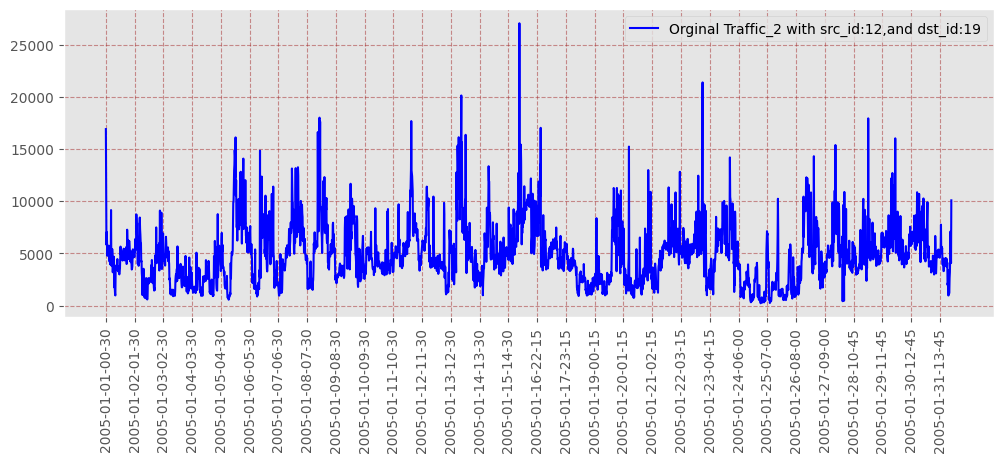

In [15]:
row = 2
plot_graph(dataframe=traffic_dataframe,row=row,decompose=False,additional_title= 'Orginal')


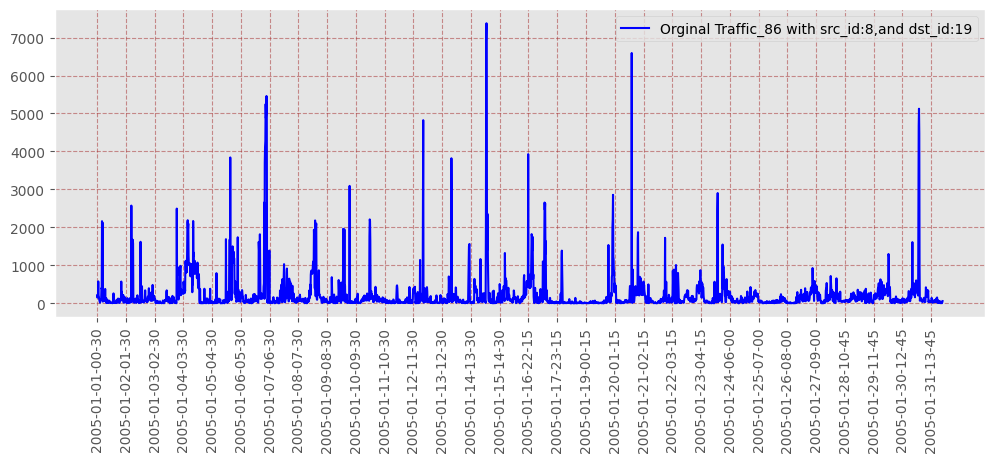

In [16]:
row = 86
plot_graph(dataframe=traffic_dataframe,row=row,decompose=False,additional_title= 'Orginal')

## g) Save clean dataframe to use later

In [17]:
traffic_dataframe.to_csv('clean_traffic_dataframe_with_outliers.csv',index=True)
traffic_dataframe

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
index,,,,,,,,,,,,,,,,,,,,,
traffic_0,12.0,12.0,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
traffic_1,12.0,13.0,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
traffic_2,12.0,19.0,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
traffic_3,12.0,23.0,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,...,194.088898,726.826721,4217.244629,16669.822266,17209.421875,8732.426758,62.880001,412.213287,166.906693,119.040001
traffic_4,12.0,8.0,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
traffic_434,15.0,2.0,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
traffic_435,15.0,11.0,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
traffic_436,15.0,9.0,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607


## h) Anomaolay detection

In [18]:
def show_anomalies(row):
  plt.style.use('ggplot')
  clean_traffic_dataframe_with_anomalies = pd.read_csv('clean_traffic_dataframe_with_outliers.csv',index_col=0)
  new_df = clean_traffic_dataframe_with_anomalies.copy()
  new_df.drop(['src_id','dst_id'],axis=1,inplace=True) # drop src_id and dst_id
  new_df = new_df.T # Transpose


  # convert string to datetime
  ##########################################
  date_format = "%Y-%m-%d-%H-%M"
  date_timestapms = [ datetime.strptime(timestamp, date_format) for timestamp in timestamps]
  new_df.index = date_timestapms
  new_df.index.name = 'time'


  # Find anomalies
  ##########################################
  c = 10.0
  window_size = 20
  traffic = new_df[[f'traffic_{row}']]
  traffic = validate_series(traffic)
  persist_ad = PersistAD(c=c)
  persist_ad.window = window_size
  anomalies = persist_ad.fit_detect(traffic)

  # Bring anomailes to an appropriate format
  ##########################################
  anomalies[anomalies[f'traffic_{row}']==True].index
  anomaly_index = anomalies[anomalies[f'traffic_{row}']==True].index
  anomaly_values = traffic.loc[anomaly_index].values
  found_anomalies = pd.DataFrame({'Values':np.squeeze(anomaly_values)},index= anomaly_index)

  raw_anomalies = anomalies.copy()
  raw_anomalies.index = [i for i in range(2941)]
  raw_anomalies = raw_anomalies[raw_anomalies[f'traffic_{row}']==True].index
  raw_anomalies_postions = raw_anomalies
  raw_anomalies_postions +=2



  # Plot 1
  fig, ax = plt.subplots(figsize=(12, 4))

  df_index = clean_traffic_dataframe_with_anomalies.iloc[row,2:].index
  df_index = [ datetime.strptime(timestamp, date_format) for timestamp in df_index]
  df_values = clean_traffic_dataframe_with_anomalies.iloc[row,2:].values
  plt.plot(df_index,df_values,c = 'b',label='Traffic')
  plt.scatter(anomaly_index,anomaly_values,c='r',label='Outlier')
  plt.title(f'Traffic_{row} with recognized outliers')
  plt.legend()
  plt.show()



  # Trun ouliers to NaN . And them fill nan
  clean_traffic_dataframe_with_anomalies.iloc[row,raw_anomalies_postions] = [np.nan for i in range(len(raw_anomalies_postions))]
  clean_traffic_dataframe_with_anomalies = clean_traffic_dataframe_with_anomalies.T
  clean_traffic_dataframe_with_anomalies.ffill(inplace=True)
  clean_traffic_dataframe_with_anomalies = clean_traffic_dataframe_with_anomalies.T

  # Plot 2
  fig, ax = plt.subplots(figsize=(12, 4))

  df_index = clean_traffic_dataframe_with_anomalies.iloc[row,2:].index
  df_index = [ datetime.strptime(timestamp, date_format) for timestamp in df_index]
  df_values = clean_traffic_dataframe_with_anomalies.iloc[row,2:].values
  plt.plot(df_index,df_values,c = 'b',label='Traffic')
  plt.title(f'Traffic_{row} after removing outliers')
  plt.legend()
  plt.show()

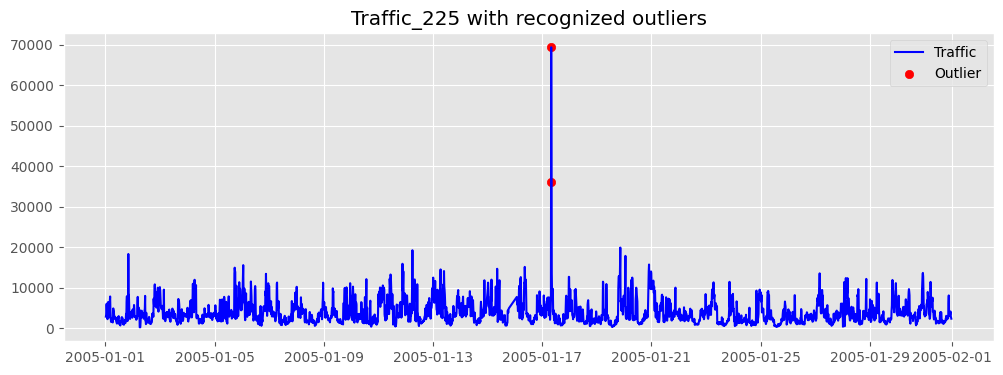

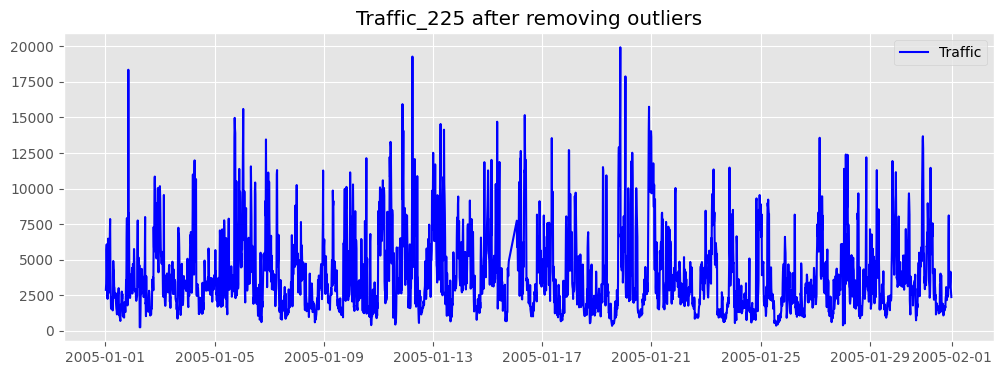

In [19]:
show_anomalies(225)

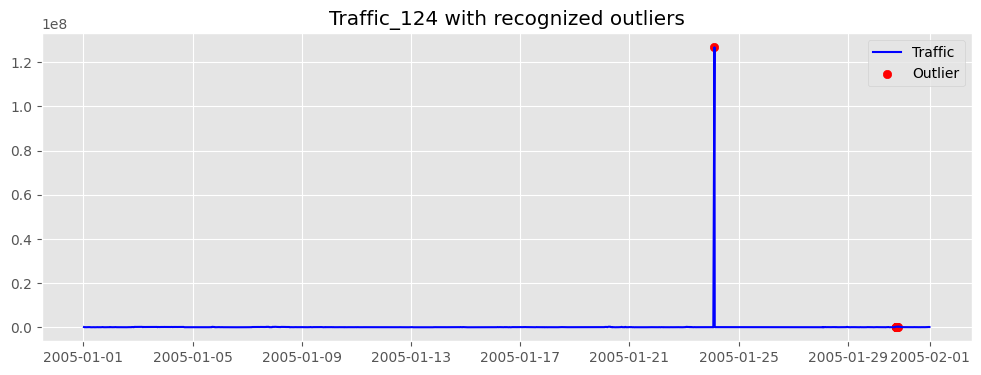

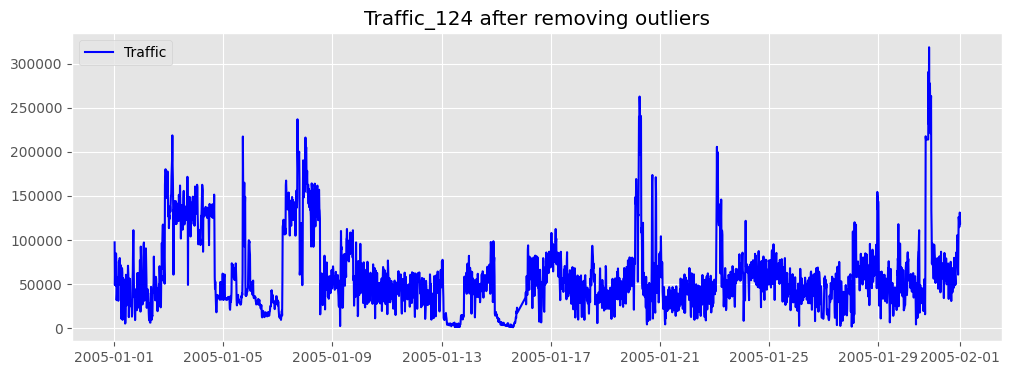

In [21]:
show_anomalies(124)

In [22]:
def remove_anamalies(clean_traffic_dataframe_with_anomalies):

  new_df = clean_traffic_dataframe_with_anomalies.copy()
  new_df.drop(['src_id','dst_id'],axis=1,inplace=True) # drop src_id and dst_id
  new_df = new_df.T # Transpose


  # convert string to datetime
  ##########################################
  date_format = "%Y-%m-%d-%H-%M"
  date_timestapms = [ datetime.strptime(timestamp, date_format) for timestamp in timestamps]
  new_df.index = date_timestapms
  new_df.index.name = 'time'


  # Find anomalies
  ##########################################
  c = 5.0
  window_size = 20
  for row in tqdm(range(439),'We are finding outliers. Please wait'):

    traffic = new_df[[f'traffic_{row}']]
    traffic = validate_series(traffic)
    persist_ad = PersistAD(c=c)
    persist_ad.window = window_size
    anomalies = persist_ad.fit_detect(traffic)

    # Bring anomailes to an appropriate format
    ##########################################
    anomalies[anomalies[f'traffic_{row}']==True].index
    anomaly_index = anomalies[anomalies[f'traffic_{row}']==True].index
    anomaly_values = traffic.loc[anomaly_index].values
    found_anomalies = pd.DataFrame({'Values':np.squeeze(anomaly_values)},index= anomaly_index)

    raw_anomalies = anomalies.copy()
    raw_anomalies.index = [i for i in range(2941)]
    raw_anomalies = raw_anomalies[raw_anomalies[f'traffic_{row}']==True].index
    raw_anomalies_postions = raw_anomalies
    raw_anomalies_postions +=2



    # Trun ouliers to NaN . And them fill nan
    clean_traffic_dataframe_with_anomalies.iloc[row,raw_anomalies_postions] = [np.nan for i in range(len(raw_anomalies_postions))]
    clean_traffic_dataframe_with_anomalies = clean_traffic_dataframe_with_anomalies.T
    clean_traffic_dataframe_with_anomalies.ffill(inplace=True)
    clean_traffic_dataframe_with_anomalies = clean_traffic_dataframe_with_anomalies.T



  return clean_traffic_dataframe_with_anomalies

In [23]:
clean_traffic_dataframe_with_anomalies =  pd.read_csv('clean_traffic_dataframe_with_outliers.csv',index_col=0)
clean_traffic_dataframe_without_anomalies = remove_anamalies(clean_traffic_dataframe_with_anomalies)

We are finding outliers. Please wait: 100%|██████████| 439/439 [00:32<00:00, 13.34it/s]


In [24]:
clean_traffic_dataframe_without_anomalies.to_csv('clean_traffic_dataframe_without_anomalies.csv')
clean_traffic_dataframe_without_anomalies

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
index,,,,,,,,,,,,,,,,,,,,,
traffic_0,12.0,12.0,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
traffic_1,12.0,13.0,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
traffic_2,12.0,19.0,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
traffic_3,12.0,23.0,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,...,194.088898,726.826721,4217.244629,4217.244629,4217.244629,8732.426758,62.880001,412.213287,166.906693,119.040001
traffic_4,12.0,8.0,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
traffic_434,15.0,2.0,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
traffic_435,15.0,11.0,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
traffic_436,15.0,9.0,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607
